In [164]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from termcolor import colored
from scipy.optimize import newton
from matplotlib.colors import PowerNorm

<div class="alert alert-info" align="center"><b>DONNÉES ATMOSPHÈRE STANDARD</b></div>

In [165]:
ATM_SEA_LEVEL = {
    'Pressure': 101325,
    'Temperature': 288.15,
    'Density': 1.225,
    'Viscosity': 1.458 * 1e-6,
    'Tz': -6.5*1e-3,
    'gamma': 1.4,
    'r_air': 8.314 / (28.966*1e-3),
    'Cp': ((8.314 / (28.966*1e-3)) * 1.4) / (1.4 - 1),
    'Cv': (8.314 / (28.966*1e-3)) / (1.4 - 1),
    'gravity': 9.80665
}

<div class="alert alert-info" align="center"><b>DONNÉES ATMOSPHÈRE A Z</b></div>

In [166]:
z = 2500

def Get_ATM_at_Z(ATM_SEA_LEVEL, z) -> dict:

    Pressure_Z = ATM_SEA_LEVEL["Pressure"] * (1 + (ATM_SEA_LEVEL["Tz"]/ATM_SEA_LEVEL["Temperature"])* z) ** (- ATM_SEA_LEVEL["gravity"] / (ATM_SEA_LEVEL["Tz"] * ATM_SEA_LEVEL["r_air"]))

    Temperature_Z = ATM_SEA_LEVEL["Temperature"] + z * ATM_SEA_LEVEL["Tz"]

    Density_Z = Pressure_Z / (Temperature_Z * ATM_SEA_LEVEL["r_air"])

    Viscosity_Z = ATM_SEA_LEVEL["Viscosity"] * ( Temperature_Z ** (3/2) / (110.4 + Temperature_Z))

    ATM_Z_LEVEL = {
        'Pressure': Pressure_Z,
        'Temperature': Temperature_Z,
        'Density': Density_Z,
        'Viscosity': Viscosity_Z
    }

    return ATM_Z_LEVEL

ATM_Z_LEVEL = Get_ATM_at_Z(ATM_SEA_LEVEL=ATM_SEA_LEVEL, z=z)
print(ATM_Z_LEVEL)

{'Pressure': 74680.39804783529, 'Temperature': 271.9, 'Density': 0.956920641332657, 'Viscosity': 1.7098855310161405e-05}


<div class="alert alert-success" align="center"><b>CLASSE CONCERNANT LES CHOCS DROITS</b></div>

In [167]:
class StateVarForNormalShock:

    def __init__(self, ATM_SEA_LEVEL, ATM_Z_LEVEL, altitude, path, FreeFlowVelocity) -> None:

        self.ABACUS = self.LoadAbacus(path=path)

        self.MachNumberInf = self.Get_MachNumber(ATM_SEA_LEVEL=ATM_SEA_LEVEL, ATM_Z_LEVEL=ATM_Z_LEVEL, FreeFlowVelocity=FreeFlowVelocity)

        self.AfterNormalShockAbacus = self.CheckInAbacus(ATM_Z_LEVEL=ATM_Z_LEVEL)
        self.VarAfterNormalShock = self.Get_StateVar(ATM_SEA_LEVEL=ATM_SEA_LEVEL, ATM_Z_LEVEL=ATM_Z_LEVEL)
        self.Graphics(altitude=altitude, FreeFlowVelocity=FreeFlowVelocity)

        self.RelativeError = self.ValuesComparison()

    def LoadAbacus(self, path):

        def CheckDataDType( Abacus):

            for col in Abacus.columns.tolist():
                Abacus[col] = Abacus[col].astype(float)

            return Abacus

        try:
            NormalShock_path = os.path.join(path, "NormalShockProperties.csv")
            try:
                NormalShock = CheckDataDType(Abacus=pd.read_csv(NormalShock_path, sep=';'))
            except Exception as error1:
                print(f"{colored('ERROR', 'red')} : {error1}")
            print(f"{colored('Abacus loading complete!', 'green')}")
        except Exception as error2:
            print(f"{colored('ERROR', 'red')} : {error2}")

        return NormalShock

    def Get_MachNumber(self, ATM_SEA_LEVEL, ATM_Z_LEVEL, FreeFlowVelocity) -> float:
        SoundSpeed = np.sqrt(ATM_SEA_LEVEL["gamma"] * ATM_SEA_LEVEL["r_air"] * ATM_Z_LEVEL["Temperature"])
        Mach = FreeFlowVelocity / SoundSpeed
        return Mach
    
    def CheckInAbacus(self, ATM_Z_LEVEL):
        
        column_index = [1, 2, 3, 6]
        AfterNormalShockAbacus = {}
        column_name = ["Pressure", "Density", "Temperature", "MachNumber"]

        for idx, col in enumerate(column_index):
            column = self.ABACUS.columns[col]
            diff = (self.ABACUS["Mach"] - self.MachNumberInf).abs()
            closest_idx = diff.nsmallest(2).index
            M1, M2 = self.ABACUS.loc[closest_idx, "Mach"]
            y1, y2 = self.ABACUS.loc[closest_idx, self.ABACUS.columns[col]]

            y = ((self.MachNumberInf - M1) / (M2 - M1)) * (y2 - y1) + y1
            
            if column_name[idx] != "MachNumber":
                AfterNormalShockAbacus[column_name[idx]] = y * ATM_Z_LEVEL[column_name[idx]]
            else:
                AfterNormalShockAbacus[column_name[idx]] = y 
                
        return AfterNormalShockAbacus

    def Get_StateVar(self, ATM_SEA_LEVEL, ATM_Z_LEVEL) -> dict:

        gamma = ATM_SEA_LEVEL['gamma']
        Pressure_Z = ATM_Z_LEVEL["Pressure"]
        Temperature_Z = ATM_Z_LEVEL["Temperature"]
        Density_Z = ATM_Z_LEVEL["Density"]

        Mach_AfterShock = np.sqrt(np.divide((gamma - 1) * self.MachNumberInf**2 + 2, 2 * gamma * self.MachNumberInf**2 - (gamma + 1)))

        Pressure_AfterShock = ((2 * gamma * self.MachNumberInf**2) / (gamma + 1) - ((gamma - 1) / (gamma + 1))) * Pressure_Z

        Temperature_AfterShock = (((1 + 0.5 * (gamma - 1) * self.MachNumberInf**2) * (((2 * gamma) / (gamma - 1)) * self.MachNumberInf**2 - 1)) / (self.MachNumberInf**2 * ((gamma + 1)**2/(2 * (gamma - 1))))) * Temperature_Z

        Density_AfterShock = (((gamma + 1) * self.MachNumberInf**2) / ((gamma - 1) * self.MachNumberInf**2 + 2)) * Density_Z

        SoundSpeed = np.sqrt(ATM_SEA_LEVEL['r_air'] * gamma * Temperature_AfterShock)
        Velocity = Mach_AfterShock * SoundSpeed

        VarAfterNormalShock = {
            'MachNumber': Mach_AfterShock,
            'Pressure': Pressure_AfterShock,
            'Temperature': Temperature_AfterShock,
            'Density': Density_AfterShock,
            'SoundSpeed': SoundSpeed,
            'Velocity': Velocity
        }

        return VarAfterNormalShock
    
    def Graphics(self, altitude, FreeFlowVelocity):

        AfterShockStateVar = self.VarAfterNormalShock
        AfterNormalShockAbacus = self.AfterNormalShockAbacus

        fig, axs = plt.subplots(3, 2, figsize=(15, 9), gridspec_kw={'height_ratios': [1, 1, 1]}, sharex=True)
        
        fig.suptitle(f"Flow Characteristics Evolution at z = {altitude} m for a Normal Shock ($\\beta = \\frac{{\pi}}{{2}}$)", fontsize=18)

        x_neg = np.array([-10, 0])
        x_pos = np.array([0, 10])

        axs[0, 0].plot(x_neg, np.full(len(x_neg), ATM_Z_LEVEL["Pressure"]), c='navy', linewidth=2, label="Before Shock")
        axs[0, 0].plot(x_pos, np.full(len(x_pos), AfterShockStateVar["Pressure"]), c='orange', linewidth=2, label="After Shock")
        axs[0, 0].plot(x_pos, np.full(len(x_pos), AfterNormalShockAbacus["Pressure"]), c='green', linestyle='--', linewidth=1, label="Abacus value")
        axs[0, 0].axvline(x=0, color='r', linestyle='--', label='Shock', linewidth=2.5)
        axs[0, 0].grid(True)
        axs[0, 0].set_title('Pressure Evolution')
        axs[0, 0].set_yscale('log')
        axs[0, 0].set_ylabel(r"$Pressure [Pa]$")
        axs[0, 0].legend()

        axs[0, 1].plot(x_neg, np.full(len(x_neg), ATM_Z_LEVEL["Temperature"]), c='navy', linewidth=2, label="Before Shock")
        axs[0, 1].plot(x_pos, np.full(len(x_pos), AfterShockStateVar["Temperature"]), c='orange', linewidth=2, label="After Shock")
        axs[0, 1].plot(x_pos, np.full(len(x_pos), AfterNormalShockAbacus["Temperature"]), c='green', linestyle='--', linewidth=1, label="Abacus value")
        axs[0, 1].axvline(x=0, color='r', linestyle='--', label='Shock', linewidth=2.5)
        axs[0, 1].grid(True)
        axs[0, 1].set_title('Temperature Evolution')
        axs[0, 1].set_ylabel(r"$Temperature [K]$")
        axs[0, 1].legend()

        axs[1, 0].plot(x_neg, np.full(len(x_neg), ATM_Z_LEVEL["Density"]), c='navy', linewidth=2, label="Before Shock")
        axs[1, 0].plot(x_pos, np.full(len(x_pos), AfterShockStateVar["Density"]), c='orange', linewidth=2, label="After Shock")
        axs[1, 0].plot(x_pos, np.full(len(x_pos), AfterNormalShockAbacus["Density"]), c='green', linestyle='--', linewidth=1, label="Abacus value")
        axs[1, 0].axvline(x=0, color='r', linestyle='--', label='Shock', linewidth=2.5)
        axs[1, 0].grid(True)
        axs[1, 0].set_title('Density Evolution')
        axs[1, 0].set_ylabel(r"Density $[kg.m^{-3}]$")
        axs[1, 0].legend()

        axs[1, 1].plot(x_neg, np.full(len(x_neg), self.MachNumberInf), c='navy', linewidth=2, label="Before Shock")
        axs[1, 1].plot(x_pos, np.full(len(x_pos), AfterShockStateVar["MachNumber"]), c='orange', linewidth=2, label="After Shock")
        axs[1, 1].plot(x_pos, np.full(len(x_pos), AfterNormalShockAbacus["MachNumber"]), c='green', linestyle='--', linewidth=1, label="Abacus value")
        axs[1, 1].axvline(x=0, color='r', linestyle='--', label='Shock', linewidth=2.5)
        axs[1, 1].grid(True)
        axs[1, 1].set_title('Mach Number Evolution')
        axs[1, 1].set_ylabel(r"Mach")
        axs[1, 1].legend()

        fig.delaxes(axs[2, 0])
        fig.delaxes(axs[2, 1])

        ax_merged = fig.add_subplot(3, 1, 3) 
        ax_merged.plot(x_neg, np.full(len(x_neg), FreeFlowVelocity), c='navy', linewidth=2, label="Before Shock")
        ax_merged.plot(x_pos, np.full(len(x_pos), AfterShockStateVar["Velocity"]), c='orange', linewidth=2, label="After Shock")
        ax_merged.axvline(x=0, color='r', linestyle='--', label='Shock', linewidth=2.5)
        ax_merged.grid(True)
        ax_merged.set_title('Flow Velocity Evolution')
        ax_merged.set_ylabel(r"$Velocity[m.s^{-1}]$")
        ax_merged.legend()

        plt.tight_layout(rect=[0, 0, 1, 0.95])

        plt.show()
    
    def ValuesComparison(self):
        RelativeError = [(np.abs(self.AfterNormalShockAbacus[key] - self.VarAfterNormalShock[key])/np.abs(self.AfterNormalShockAbacus[key])) * 100 for key in self.AfterNormalShockAbacus.keys()] 

        print(f"Relative error between theoretical and formula values")
        for idx, key in enumerate(self.AfterNormalShockAbacus.keys()):
            print(f"    {colored(key, 'blue')} = {RelativeError[idx]} %")
        return RelativeError
    

<div class="alert alert-danger" align="center"><b>INITIALISATION</b></div>

Abacus loading complete!


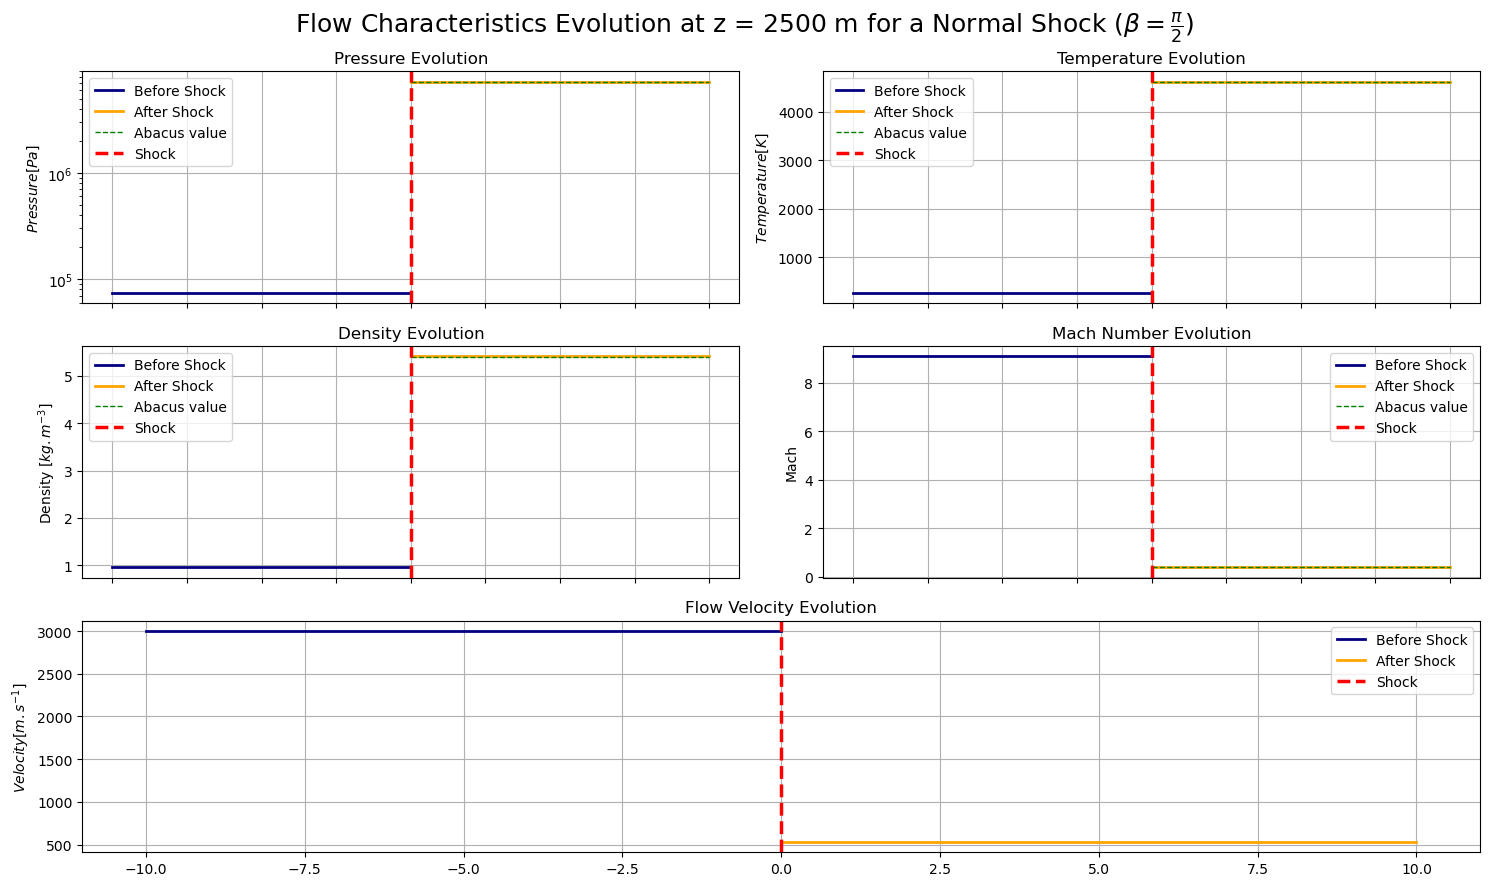

Relative error between theoretical and formula values
    Pressure = 0.0820653988989954 %
    Density = 0.015189717621278563 %
    Temperature = 0.06663886232946503 %
    MachNumber = 0.42988120067664565 %


In [168]:
Abaques_path = os.getcwd().replace("src", "Docs\Abaques")
FreeFlowVelocity = 3000 # m/s

SV_NS = StateVarForNormalShock(ATM_SEA_LEVEL, ATM_Z_LEVEL, z, Abaques_path, FreeFlowVelocity)

<div class="alert alert-success" align="center"><b>CLASSE CONCERNANT LES CHOCS OBLIQUES</b></div>

In [169]:
class StateVarForObliqueShock:

    def __init__(self, ATM_SEA_LEVEL, ATM_Z_LEVEL, StudyingProfil, altitude, FreeFlowVelocity) -> None:
        self.MachNumberInf = self.Get_MachNumber(ATM_SEA_LEVEL=ATM_SEA_LEVEL, ATM_Z_LEVEL=ATM_Z_LEVEL, FreeFlowVelocity=FreeFlowVelocity)

        self.Theta, self.Beta = self.Get_ThetaBeta(StudyingProfil=StudyingProfil, gamma=ATM_SEA_LEVEL["gamma"])
        self.ThetaMax, self.BetaMax = self.Get_ThetaBetaMax(gamma=ATM_SEA_LEVEL["gamma"])

        self.VarAfterObliqueShock = self.Get_StateVar(ATM_SEA_LEVEL=ATM_SEA_LEVEL, ATM_Z_LEVEL=ATM_Z_LEVEL)
        self.StagnationStateVar = self.Get_StagnationStateVar(gamma=ATM_SEA_LEVEL["gamma"])
        self.DispGraphics(StudyingProfil=StudyingProfil)

        self.delta_eps, self.shape_2D = self.Get_ApproxShockLayer(ATM_Z_LEVEL=ATM_Z_LEVEL, StudyingProfil=StudyingProfil)
        self.ShowGeometry(StudyingProfil=StudyingProfil)
        self.DispContour(StudyingProfil=StudyingProfil)
        
    def Get_MachNumber(self, ATM_SEA_LEVEL, ATM_Z_LEVEL, FreeFlowVelocity) -> float:
        SoundSpeed = np.sqrt(ATM_SEA_LEVEL["gamma"] * ATM_SEA_LEVEL["r_air"] * ATM_Z_LEVEL["Temperature"])
        Mach = FreeFlowVelocity / SoundSpeed
        return Mach
    
    def Get_ThetaBeta(self, StudyingProfil, gamma):

            # equation
        def cotangent(angle):
            return np.cos(angle)/np.sin(angle)
        
        def betaEquation(beta, Mach, theta, gamma):
            left_side = np.tan(theta)
            right_side = 2 * cotangent(beta) * ((Mach**2 * np.sin(beta)**2 - 1) / (Mach**2 * (gamma + np.cos(2 * beta)) + 2))
            return left_side - right_side

        Profil = StudyingProfil["Profil"]
        x = StudyingProfil["x_val"]

            # Deviation Angle
        Dgeometry = np.diff(Profil) / np.diff(x)
        Dgeometry = np.append(Dgeometry,Dgeometry[-1])
        Theta = np.arctan(Dgeometry)

            # Shock Angle
        Beta = np.zeros(len(Theta))
        for idx, theta in enumerate(Theta):
            InitBeta = np.radians(30)
            try:
                betaSol = newton(betaEquation, InitBeta, args=(self.MachNumberInf, theta, gamma), maxiter=1000, tol=1e-8)
                Beta[idx] = betaSol
                # if idx > 0 and abs(betaSol) >= abs(BetaAngleVec[idx - 1]):
                #     BetaAngleVec[idx] = 0
                # else:
                #     BetaAngleVec[idx] = betaSol

            except Exception as error:
                Beta[idx] = 0

        return Theta, Beta

    def Get_ThetaBetaMax(self, gamma):

        BetaMax = 0.5 * np.arccos(((self.MachNumberInf**2 * (gamma - 1) + 4 - np.sqrt(16 * (gamma + 1) + 8 * self.MachNumberInf**2 * (gamma**2 - 1) + self.MachNumberInf**4 * (gamma + 1)**2)))/(2 * gamma * self.MachNumberInf**2))
        
        ThetaMax = np.arctan(
            (2 * (self.MachNumberInf**2 * np.sin(BetaMax)**2 - 1))/(np.tan(BetaMax) * (2 + self.MachNumberInf**2 * (gamma + np.cos(2 * BetaMax))))
        )

        return ThetaMax, BetaMax
    
    def Get_StateVar(self, ATM_SEA_LEVEL, ATM_Z_LEVEL) -> dict:

        gamma = ATM_SEA_LEVEL['gamma']
        Pressure_Z = ATM_Z_LEVEL["Pressure"]
        Temperature_Z = ATM_Z_LEVEL["Temperature"]
        Density_Z = ATM_Z_LEVEL["Density"]

        Mach_inf_n = self.MachNumberInf * np.sin(self.Beta)
        Mach_AfterShock_n = np.sqrt(np.divide((gamma - 1) * Mach_inf_n**2 + 2, 2 * gamma * Mach_inf_n**2 - (gamma + 1)))
        Mach_AfterShock = Mach_AfterShock_n / np.sin(self.Beta - self.Theta)

        Pressure_AfterShock = ((2 * gamma * Mach_inf_n**2) / (gamma + 1) - ((gamma - 1) / (gamma + 1))) * Pressure_Z

        Temperature_AfterShock = (((1 + 0.5 * (gamma - 1) * Mach_inf_n**2) * (((2 * gamma) / (gamma - 1)) * Mach_inf_n**2 - 1)) / (Mach_inf_n**2 * ((gamma + 1)**2/(2 * (gamma - 1))))) * Temperature_Z

        Density_AfterShock = (((gamma + 1) * Mach_inf_n**2) / ((gamma - 1) * Mach_inf_n**2 + 2)) * Density_Z

        SoundSpeed = np.sqrt(ATM_SEA_LEVEL['r_air'] * gamma * Temperature_AfterShock)
        Velocity = Mach_AfterShock * SoundSpeed

        VarAfterObliqueShock = {
            'Mach_2_n': Mach_AfterShock_n,
            'Mach_2': Mach_AfterShock,
            'Pressure': Pressure_AfterShock,
            'Temperature': Temperature_AfterShock,
            'Density': Density_AfterShock,
            'SoundSpeed': SoundSpeed,
            'Velocity':Velocity
        }

        return VarAfterObliqueShock
    
    def Get_StagnationStateVar(self, gamma) -> dict:

        Pressure_stag = (1 + 0.5 * (gamma -1) * self.VarAfterObliqueShock["Mach_2_n"]**2)**(gamma/(gamma - 1)) * self.VarAfterObliqueShock["Pressure"]

        Temperature_stag = (1 + 0.5 * (gamma -1) * self.VarAfterObliqueShock["Mach_2_n"]**2) * self.VarAfterObliqueShock["Temperature"]

        Density_stag = (1 + 0.5 * (gamma -1) * self.VarAfterObliqueShock["Mach_2_n"]**2)**(1/(gamma - 1)) * self.VarAfterObliqueShock["Density"]

        SoundSpeed_stag = (1 + 0.5 * (gamma -1) * self.VarAfterObliqueShock["Mach_2_n"]**2)**(1/2) * self.VarAfterObliqueShock["SoundSpeed"]

        StagnationStateVar = {
            "Pressure": Pressure_stag,
            "Temperature": Temperature_stag,
            "Density": Density_stag,
            "SoundSpeed_stag": SoundSpeed_stag,
        }

        return StagnationStateVar

    def DispGraphics(self, StudyingProfil):
        x_val = StudyingProfil["x_val"]
        
        fig, axs = plt.subplots(3, 2, figsize=(15, 9), gridspec_kw={'height_ratios': [1, 1, 1]}, sharex=True)

        axs[0, 0].plot(x_val, self.VarAfterObliqueShock["Pressure"], label="Pressure downstream of impact", c='navy')
        axs[0, 0].plot(x_val, self.StagnationStateVar["Pressure"], label="Stagnation pressure", c='orange', linestyle='-.')
        axs[0, 0].grid('on')
        axs[0, 0].set_yscale('log')
        axs[0, 0].set_title('Pressure Evolution')
        axs[0, 0].set_ylabel(r"$Pressure [Pa]$")
        axs[0, 0].legend()

        axs[0, 1].plot(x_val, self.VarAfterObliqueShock["Temperature"], label="Temperature downstream of impact", c='navy')
        axs[0, 1].plot(x_val, self.StagnationStateVar["Temperature"], label="Stagnation temperature", c='orange', linestyle='-.')
        axs[0, 1].grid('on')
        axs[0, 1].set_title('Temperature Evolution')
        axs[0, 1].set_ylabel(r"$Temperature [K]$")
        axs[0, 1].legend()

        axs[1, 0].plot(x_val, self.VarAfterObliqueShock["Density"], label="Density downstream of impact", c='navy')
        axs[1, 0].plot(x_val, self.StagnationStateVar["Density"], label="Stagnation density", c='orange', linestyle='-.')
        axs[1, 0].grid('on')
        axs[1, 0].set_title('Density Evolution')
        axs[1, 0].set_ylabel(r"Density $[kg.m^{-3}]$")
        axs[1, 0].legend()

        axs[1, 1].plot(x_val, self.VarAfterObliqueShock["Mach_2_n"], c='navy', label="Normal Mach number after impact")
        axs[1, 1].plot(x_val, self.VarAfterObliqueShock["Mach_2"], c='orange', label="Mach number after impact")
        axs[1, 1].grid('on')
        axs[1, 1].set_title('Mach Number Evolution')
        axs[1, 1].set_ylabel(r"$Mach\ Number$")
        axs[1, 1].legend()

        fig.delaxes(axs[2, 0])
        fig.delaxes(axs[2, 1])
        ax_merged = fig.add_subplot(3, 1, 3) 

    def Get_ApproxShockLayer(self, ATM_Z_LEVEL, StudyingProfil):
        
        # first definition
        def f_function(epsilon):
            return epsilon * (3 * epsilon + 1.6 * epsilon**(3/2) - np.sqrt(3 * epsilon) + 1)
        
        eps = ATM_Z_LEVEL["Density"] / self.VarAfterObliqueShock["Density"]
        
        delta_eps = (f_function(epsilon=eps) / (1 - f_function(epsilon=eps))) * StudyingProfil["Radius"]

        # 2D definition
        # delta_2D = 0.193 * np.exp(4.67 / self.MachNumberInf**2) * 2 * StudyingProfil["Radius"]
        # Rc = 0.693 * np.exp(1.8 / (self.MachNumberInf - 1)**0.75)
        delta_2D = 0.386 * np.exp(4.67/self.MachNumberInf**2) * StudyingProfil["Radius"]
        Rc = 1.386 * np.exp(1.8 / (self.MachNumberInf - 1)**(0.75)) * StudyingProfil["Radius"] 
        shape_2D = StudyingProfil["Radius"] + delta_2D - Rc * np.divide(np.sqrt(1 - np.square(np.divide(StudyingProfil["Profil"] * np.tan(self.Beta), Rc))) - 1, np.tan(self.Beta)**2)

        return delta_eps, shape_2D

    def ShowGeometry(self, StudyingProfil):
        
            # Mach cone
        mu = np.arcsin(1/self.MachNumberInf)
        x_start = -9.5
        x_cone = np.linspace(x_start, np.max(StudyingProfil["x_val"]), 500)
        y_cone = (x_cone - x_start) * np.tan(mu)

        y_shape_profil = self.shape_2D + StudyingProfil["Profil"]

        # figure
        fig, ax = plt.subplots(1, figsize=(12, 7))
        fig.suptitle("Géométrie du profil en 2D", fontsize=18)
        
        ax.plot(StudyingProfil["x_val"], StudyingProfil["Profil"], c='navy', label="Profil de la fusée")
        ax.plot(StudyingProfil["x_val"], y_shape_profil, c='#387478', linestyle="--", label='Couche de choc')
        ax.plot(StudyingProfil["x_val"], - StudyingProfil["Profil"], c='navy')
        ax.plot(StudyingProfil["x_val"], - y_shape_profil, c='#387478', linestyle="--")
        ax.plot(x_cone, y_cone, 'r--', label=rf"Cône de Mach $\mu$ = {np.rad2deg(mu):.5f} $\degree$")
        ax.plot(x_cone, - y_cone, 'r--')
        ax.fill_between(StudyingProfil["x_val"], StudyingProfil["Profil"], y_shape_profil, where=(y_shape_profil > StudyingProfil["Profil"]), interpolate=True, color='#387478', alpha=0.3, hatch='//')
        
        ax.fill_between(StudyingProfil["x_val"], - StudyingProfil["Profil"], - y_shape_profil, where=(- y_shape_profil < - StudyingProfil["Profil"]), interpolate=True, color='#387478', alpha=0.3, hatch='//')

        ax.grid('true')
        ax.set_xlim([x_start, np.max(StudyingProfil["x_val"])])
        ax.set_ylim([np.min(StudyingProfil["Profil"]) - StudyingProfil["Length"]*0.05, np.min(StudyingProfil["Profil"]) + StudyingProfil["Length"]*0.05])
        ax.legend(loc='upper right')

        plt.plot()

    def DispContour(self, StudyingProfil):

        x_profil = StudyingProfil["x_val"]
        profil = StudyingProfil["Profil"]

        x = np.linspace(-10, StudyingProfil["Length"], 1000)
        y = np.linspace(-np.max(profil) - StudyingProfil["Length"]*0.1, np.max(profil) + StudyingProfil["Length"]*0.1, 1000)
        X, Y = np.meshgrid(x, y)

        choc_layer = self.shape_2D + StudyingProfil["Profil"]

        PressureMatrix = np.full((1000, 1000), ATM_Z_LEVEL["Pressure"])
        TemperatureMatrix = np.full((1000, 1000), ATM_Z_LEVEL["Temperature"])
        DensityMatrix = np.full((1000, 1000), ATM_Z_LEVEL["Density"])

        for i in range(len(x_profil)):
            if x_profil[i] >= np.min(x) and x_profil[i] <= np.max(x):

                choc_upper_bound = choc_layer[i]
                choc_lower_bound = - choc_layer[i]
                upper_bound = profil[i]
                lower_bound = -profil[i]

                # Génération des masques
                x_index = np.argmin(np.abs(x - x_profil[i]))
                inside_mask = (Y[:, x_index] >= lower_bound) & (Y[:, x_index] <= upper_bound)
                between_mask_upper = (Y[:, x_index] > upper_bound) & (Y[:, x_index] <= choc_upper_bound)
                between_mask_lower = (Y[:, x_index] < lower_bound) & (Y[:, x_index] >= choc_lower_bound)

                # Gestion de la Pression
                PressureMatrix[inside_mask, x_index] = np.nan
                PressureMatrix[between_mask_upper, x_index] = self.VarAfterObliqueShock["Pressure"][i]
                PressureMatrix[between_mask_lower, x_index] = self.VarAfterObliqueShock["Pressure"][i]

                # Gestion de la Température
                TemperatureMatrix[inside_mask, x_index] = np.nan
                TemperatureMatrix[between_mask_upper, x_index] = self.VarAfterObliqueShock["Temperature"][i]
                TemperatureMatrix[between_mask_lower, x_index] = self.VarAfterObliqueShock["Temperature"][i]

                # Gestion de la Densité
                DensityMatrix[inside_mask, x_index] = np.nan
                DensityMatrix[between_mask_upper, x_index] = self.VarAfterObliqueShock["Density"][i]
                DensityMatrix[between_mask_lower, x_index] = self.VarAfterObliqueShock["Density"][i]


        normPressure = PowerNorm(gamma=0.4, vmin=ATM_Z_LEVEL["Pressure"], vmax=np.nanmax(PressureMatrix))
        normTemperature = PowerNorm(gamma=0.4, vmin=ATM_Z_LEVEL["Temperature"], vmax=np.nanmax(TemperatureMatrix))
        normDensity = PowerNorm(gamma=0.4, vmin=ATM_Z_LEVEL["Density"], vmax=np.nanmax(DensityMatrix))

        fig, axs = plt.subplots(3, 1, figsize=(10, 12), gridspec_kw={'height_ratios': [1, 1, 1]}, sharex=True)

        contourPressure = axs[0].contourf(X, Y, PressureMatrix, levels=500, cmap='jet', norm=normPressure)
        contourTemperature = axs[1].contourf(X, Y, TemperatureMatrix, levels=500, cmap='jet', norm=normTemperature)
        contourDensity = axs[2].contourf(X, Y, DensityMatrix, levels=500, cmap='jet', norm=normDensity)

        fig.colorbar(contourPressure, ax=axs[0], label=r"$Pressure\ variation\ [Pa]$")
        axs[0].plot(x_profil, profil, color='black', label='Profil')
        axs[0].fill_between(x_profil, profil, color='k', alpha=0.5, hatch='//')
        axs[0].plot(x_profil, -profil, color='black')
        axs[0].fill_between(x_profil, -profil, color='k', alpha=0.5, hatch='//')
        axs[0].plot(x_profil, choc_layer, color='#387478', linestyle='-.', label='Shock layer')
        axs[0].plot(x_profil, -choc_layer, color='#387478', linestyle='-.')
        axs[0].set_title("Pressure variation")
        axs[0].set_xlim([-10, StudyingProfil["Length"]])
        axs[0].set_ylim([np.min(StudyingProfil["Profil"]) - StudyingProfil["Length"]*0.05, np.min(StudyingProfil["Profil"]) + StudyingProfil["Length"]*0.05])
        axs[0].legend()

        fig.colorbar(contourTemperature, ax=axs[1], label=r"$Temperature\ variation\ [K]$")
        axs[1].plot(x_profil, profil, color='black', label='Profil')
        axs[1].fill_between(x_profil, profil, color='k', alpha=0.5, hatch='//')
        axs[1].plot(x_profil, -profil, color='black')
        axs[1].fill_between(x_profil, -profil, color='k', alpha=0.5, hatch='//')
        axs[1].plot(x_profil, choc_layer, color='#387478', linestyle='-.', label='Shock layer')
        axs[1].plot(x_profil, -choc_layer, color='#387478', linestyle='-.')
        axs[1].set_title("Temperature variation")
        axs[1].set_xlim([-10, StudyingProfil["Length"]])
        axs[1].set_ylim([np.min(StudyingProfil["Profil"]) - StudyingProfil["Length"]*0.05, np.min(StudyingProfil["Profil"]) + StudyingProfil["Length"]*0.05])
        axs[1].legend()

        fig.colorbar(contourDensity, ax=axs[2], label=r"$Density\ variation\ [kg.m^{-3}]$")
        axs[2].plot(x_profil, profil, color='black', label='Profil')
        axs[2].fill_between(x_profil, profil, color='k', alpha=0.5, hatch='//')
        axs[2].plot(x_profil, -profil, color='black')
        axs[2].fill_between(x_profil, -profil, color='k', alpha=0.5, hatch='//')
        axs[2].plot(x_profil, choc_layer, color='#387478', linestyle='-.', label='Shock layer')
        axs[2].plot(x_profil, -choc_layer, color='#387478', linestyle='-.')
        axs[2].set_title("Density variation")
        axs[2].set_xlim([-10, StudyingProfil["Length"]])
        axs[2].set_ylim([np.min(StudyingProfil["Profil"]) - StudyingProfil["Length"]*0.05, np.min(StudyingProfil["Profil"]) + StudyingProfil["Length"]*0.05])
        axs[2].legend()

<div class="alert alert-danger" align="center"><b>INITIALISATION</b></div>

In [170]:
length = 50
radius = 0.75
x = np.linspace(0, length, 1000)
y = radius * (1 + np.sqrt(1 - ((length - x) / length)**2)) - radius

StudyingProfil = {
    'Profil': y,
    'Radius': radius,
    'Length': length,
    'x_val': x,
}

SV_OS = StateVarForObliqueShock(ATM_SEA_LEVEL=ATM_SEA_LEVEL, ATM_Z_LEVEL=ATM_Z_LEVEL, StudyingProfil=StudyingProfil, altitude=z, FreeFlowVelocity=FreeFlowVelocity)
Mach_inf = SV_OS.MachNumberInf
Beta = SV_OS.Beta
VarAfterObliqueShock = SV_OS.VarAfterObliqueShock